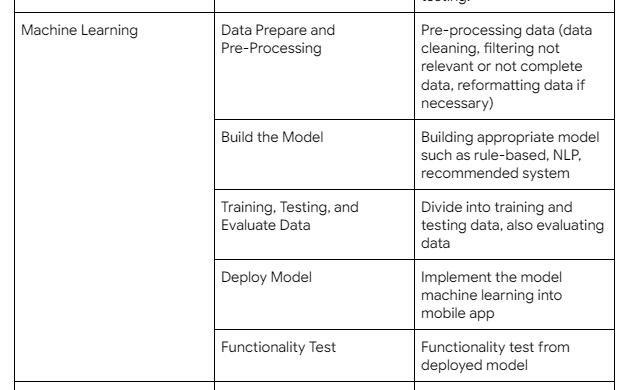

Machine Learning bakal melakukan : 
1. Model sistem pencarian, misal "lake", maka akan muncul lake-lake. 
Dengan pertimbangan sebagai berikut ->
- Kategori (Rule based)
- Lokasi (Rule based)
- Rating google maps (Collaborative filtering or content based-filtering)
- Review google maps. Pake analisis sentimen bisa meneggunakan RNN atau transformer
2. Search box, 
- Gabungkan semua komponen tersebut
- Gunakan review dari users untuk menentukan kategori, lokasi, dan preferensi lainnya dalam pencarian (untuk informasi tambahan)

Tambahan ->
- Menggunakan algoritma pemeringkatan untuk memberikan bobot untuk mesin pencarian
- Model machine learning terpisah dari rating dan review. Untuk kategori dan lokasi bisa tanpa memisahkan model ML. Untuk kategori bisa menggunakan aturan if-else atau pemrosesan teks sederhana. Untuk lokasi bisa menggunakan aturan geografis koordinat atau kata kunci lokai.

Output ->
1. Kategori
berdasarkan kategori yang ada di gmaps api. dari database, ada kolom kategori
2. Lokasi
berdasarkan kategori yang ada di gmaps api. dari database, ada kolom kategori
3. Rating
collaborative -> ikut pola selera/ algoritma org lain
content-based filtering -> berdasarkan relevansi konten
4. Review
analisis sentimen -> ambil yang positif teratas
mungkin tambahan jika banyak waktu -> referensi tambahan untuk lokasi dan kategori

aku jd mikir, jadi ada 2 fitur.
1. fitur search box buat nyari "lake", nanti bakal ketemu lake
--> menggunakan kategori, lokasi, review.
2. fitur di dashboard, kek rekomendasi (kalau misal di spotify ada rekomen playlist).
--> menggunakan rating.

pertama bikin fitur search box dulu
baru bikin fitur rekomen tadi



# UPDATE 17.5.2023
1. Search engine menggunakan sentimen analysis
- Pre processing data dan prepare -> collect manual dari google maps review
- build model -> pake analysis sentimen
- training evaluating -> di sini
- prediksi -> menggunakan google maps api
caranya prediksi review terbaru
(mungkin 5 review teratas) pada review google maps. Jadi pada search engine, jika ngetik "lake", maka filter kategori, terus cari lokasi yang deket (longitude latitude terdekat sama lokasi sekarang), baru analisis sentimen.


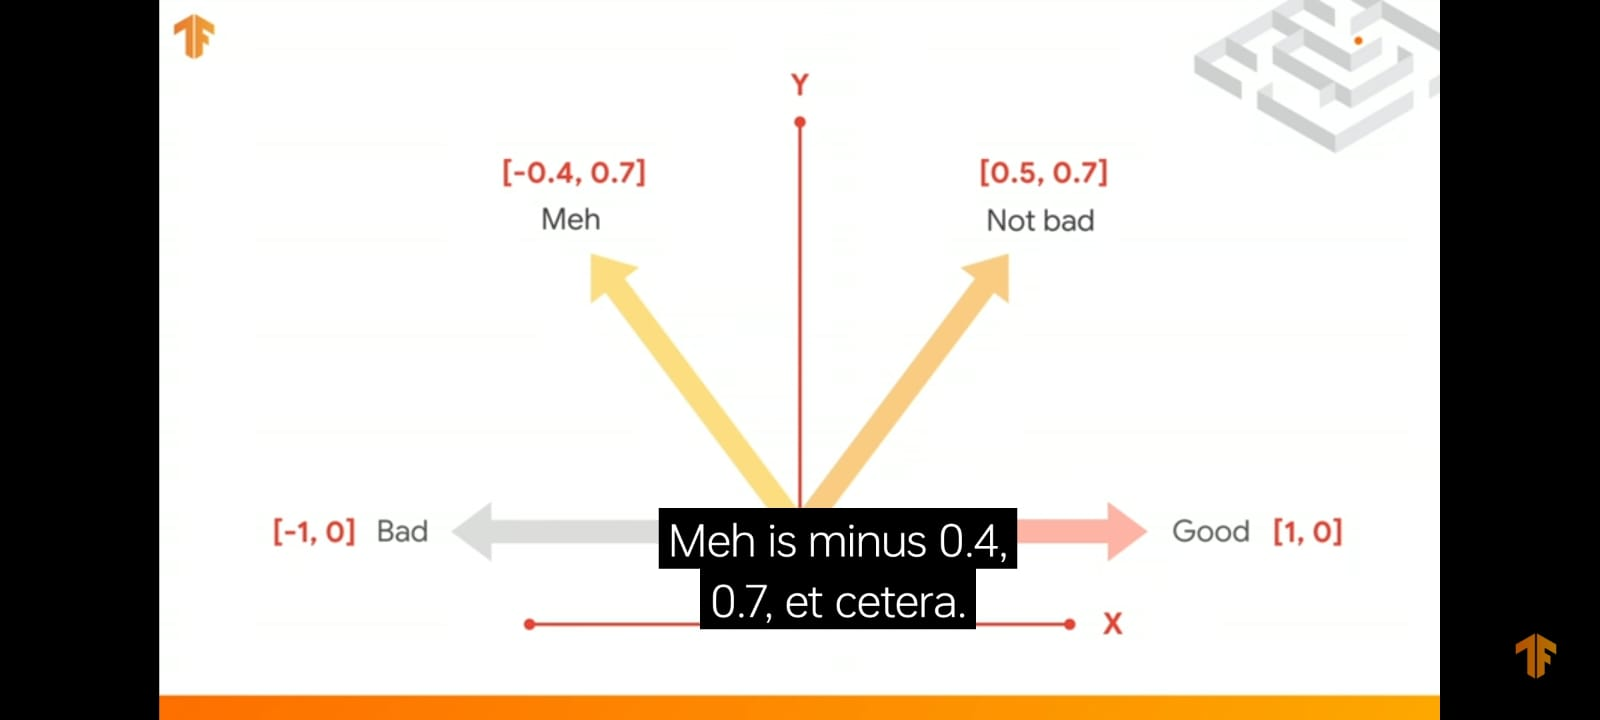

## Analisis sentimen
dari foto diatas, jadi analisis sentimen ada rentang angkanya buat tiap kalimat. Jadi rencananya bakal ngitungin angka analisis sentimen buat mempertimbangkan tempat mana yang di google maps yang punya angka sentimen paling besar.

2. Sekarang masih ngumpulin data (reviews) buat ditraining
3. ML ngerjain buat search box dulu, buat recomendasi sistem nanti dipikirin (karena butuh data user dan rating dari google maps)

# **BUILD SEARCH BOX WITH NLP SENTIMENT ANALYSIS**
referensi : https://www.youtube.com/watch?v=Y_hzMnRXjhI

## Data Preparation

### MOUNT DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/Classroom/sentiment140.zip -d /content/

### USE TENSORFLOW

In [ ]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### IMPORT LIBRARY

In [ ]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import csv
import pandas as pd


In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 1200


In [ ]:
#!wget --no-check-certificate \
    #https://storage.googleapis.com/learning-datasets/sarcasm.json \
    #-O /tmp/sarcasm.json


## Importing the data files
After importing the necessary libraries now we will read the data files we have two data files here



In [ ]:
with open("/content/drive/MyDrive/Classroom/datasetFIT (2).json", 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['texts'])
    labels.append(item['target'])
    

In [ ]:
for i in range(len(datastore)):
    print(f"{datastore[i]}")

{'target': 0, 'texts': 'Monday, Many tours in Surabaya are closed.'}
{'target': 1, 'texts': 'Great Place for sightseeing and spending time with friends or family'}
{'target': 1, 'texts': 'Cool place, comfortable, clean, unlike other squares, this place has a unique architecture and layout'}
{'target': 1, 'texts': 'Place of education for the citizens of Surabaya in particular and society in general.'}
{'target': 1, 'texts': 'Really good'}
{'target': 1, 'texts': 'Lots of good smooth'}
{'target': 1, 'texts': 'Clean, well-maintained, bright and cool'}
{'target': 1, 'texts': "The Suroboyo children's creative activity center is here. Always well maintained by the municipal government of Surabaya"}
{'target': 1, 'texts': "I've been here several times and this is the first time the smoke from the fountain appears, yeeaay..."}
{'target': 1, 'texts': 'Very good, very familyable'}
{'target': 1, 'texts': 'Unique'}
{'target': 1, 'texts': 'Surabaya icon Exciting'}
{'target': 1, 'texts': 'Surabaya re

## Preprocessing the data

In [ ]:
# Membuat DataFrame contoh
df = pd.DataFrame(datastore)

# Menampilkan beberapa baris pertama DataFrame
print(df.head())

   target                                              texts
0       0         Monday, Many tours in Surabaya are closed.
1       1  Great Place for sightseeing and spending time ...
2       1  Cool place, comfortable, clean, unlike other s...
3       1  Place of education for the citizens of Surabay...
4       1                                        Really good


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  1524 non-null   int64 
 1   texts   1524 non-null   object
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


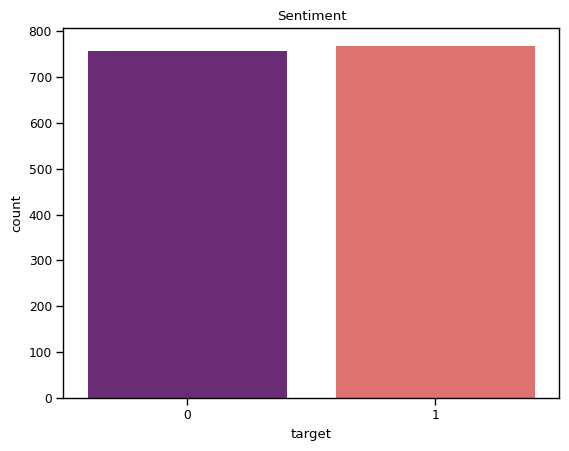

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
sns.set_context('paper')

# create plot
sns.countplot(x = 'target', data = df, palette = 'magma')
plt.title('Sentiment')
plt.show()

## TRAINING DATA

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
training_labels

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# grader-required-cell

# GRADED FUNCTION: n_gram_seqs
#def n_gram_seqs(training_sentences, tokenizer):
	#input_sequences = []

	### START CODE HERE

	#for line in corpus:
	#	token_list = tokenizer.texts_to_sequences([line])[0]
#
	#	for i in range(1, len(token_list)):
	#		# Generate subphrase
	#		n_gram_sequence = token_list[:i+1]
			# Append subphrase to input_sequences list
		#	input_sequences.append(n_gram_sequence)
	
	### END CODE HERE
	# 
#	return input_sequences

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
jumlah_x = training_padded.shape[0]
jumlah_y = training_labels.shape[0]

jumlah_x1 = testing_padded.shape[0]
jumlah_y1 = testing_labels.shape[0]

print(jumlah_x)
print(jumlah_y)

print(jumlah_x1)
print(jumlah_y1)

1200
1200
324
324


In [ ]:
#from sklearn.preprocessing import LabelEncoder

# Membuat objek LabelEncoder
#encoder = LabelEncoder()

# Remove empty strings from the testing_labels array
#training_labels_nonull = np.array([label for label in training_labels if label != ''])
#testing_labels_nonull = np.array([label for label in testing_labels if label != ''])

# Mengonversi label menjadi tipe data numerik
#training_labels_encoded = encoder.fit_transform(training_labels_nonull)
#testing_labels_encoded = encoder.transform(testing_labels_nonull)


In [ ]:
#testing_labels_encoded

## Building the model
Our model is a neural network and it consits of the following layers : 

1.   one word embedding layer which creates word embeddings  from integer encoded review.
2.  second layer is global average pooling layer which is used to prevent overfitting by reducing the number of parameters.

1.   then a dense layer uses relu as activation function
2.  the final layer is the output layer which uses sigmoid as activation function 


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## Compiling the model


1.   Adam is used as optimization function for our model.
2.   Binary cross entropy loss function is used as loss function for the model.

1.   Accuracy is used as the metric for evaluating the model.





In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


### TRAIN THE MODEL

In [ ]:
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/50
38/38 - 6s - loss: 0.6927 - accuracy: 0.5183 - val_loss: 0.6977 - val_accuracy: 0.3858 - 6s/epoch - 154ms/step
Epoch 2/50
38/38 - 4s - loss: 0.6920 - accuracy: 0.5258 - val_loss: 0.6996 - val_accuracy: 0.3858 - 4s/epoch - 116ms/step
Epoch 3/50
38/38 - 2s - loss: 0.6908 - accuracy: 0.5258 - val_loss: 0.7007 - val_accuracy: 0.3858 - 2s/epoch - 43ms/step
Epoch 4/50
38/38 - 1s - loss: 0.6890 - accuracy: 0.5258 - val_loss: 0.7007 - val_accuracy: 0.3858 - 1s/epoch - 38ms/step
Epoch 5/50
38/38 - 1s - loss: 0.6864 - accuracy: 0.5258 - val_loss: 0.7014 - val_accuracy: 0.3858 - 878ms/epoch - 23ms/step
Epoch 6/50
38/38 - 1s - loss: 0.6820 - accuracy: 0.5375 - val_loss: 0.6994 - val_accuracy: 0.3858 - 1s/epoch - 32ms/step
Epoch 7/50
38/38 - 1s - loss: 0.6751 - accuracy: 0.5717 - val_loss: 0.6973 - val_accuracy: 0.3920 - 715ms/epoch - 19ms/step
Epoch 8/50
38/38 - 1s - loss: 0.6640 - accuracy: 0.6342 - val_loss: 0.6842 - val_accuracy: 0.5247 - 598ms/epoch - 16ms/step
Epoch 9/50
38/38 - 1s

Now we will be evaluating the loss and accuracy of our model on testing data.

In [ ]:
loss,accuracy=model.evaluate(testing_padded, testing_labels)

11/11 [==============================] - 0s 4ms/step - loss: 0.7082 - accuracy: 0.7253


## Visualization Epoch

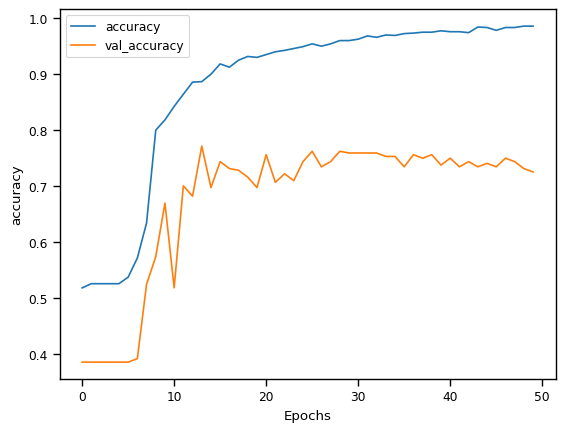

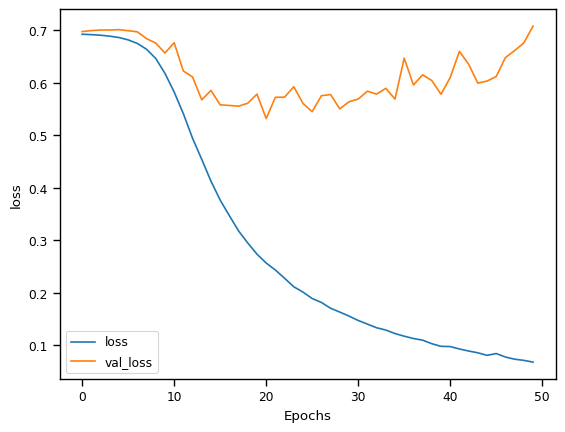

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# def decode_sentence(text):
#     return ' '.join([reverse_word_index.get(i, '?') for i in text])

# print(decode_sentence(training_padded[0]))
# print(training_sentences[2])
# print(labels[2])

In [ ]:
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)


In [ ]:
# import io

# out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# for word_num in range(1, vocab_size):
#   word = reverse_word_index[word_num]
#   embeddings = weights[word_num]
#   out_m.write(word + "\n")
#   out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
# out_v.close()
# out_m.close()

In [ ]:
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

## Predict

In [ ]:
sentence = ["good but not bad too"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 76ms/step
[[0.66497976]]


# **BUILD SEARCH BOX WITH NLP SENTIMENT ANALYSIS 2 + CNN**
referensi : https://www.youtube.com/watch?v=oWo9SNcyxlI

## Plan of Action


1.   Load **GOOGLE MAPS API REVIEW**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: ** CNN Models** and analyse model performance and results
4. Last, perform **predictions on real MAPS reviews**

## Setting Environment

In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import csv

import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

## Data Preparation (Load Data)

In [ ]:
with open("/content/drive/MyDrive/Classroom/datasetFIT (2).json", 'r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['texts'])
    labels.append(item['target'])
    

In [ ]:
for i in range(len(datastore)):
    print(f"{datastore[i]}")

{'target': 0, 'texts': 'Monday, Many tours in Surabaya are closed.'}
{'target': 1, 'texts': 'Great Place for sightseeing and spending time with friends or family'}
{'target': 1, 'texts': 'Cool place, comfortable, clean, unlike other squares, this place has a unique architecture and layout'}
{'target': 1, 'texts': 'Place of education for the citizens of Surabaya in particular and society in general.'}
{'target': 1, 'texts': 'Really good'}
{'target': 1, 'texts': 'Lots of good smooth'}
{'target': 1, 'texts': 'Clean, well-maintained, bright and cool'}
{'target': 1, 'texts': "The Suroboyo children's creative activity center is here. Always well maintained by the municipal government of Surabaya"}
{'target': 1, 'texts': "I've been here several times and this is the first time the smoke from the fountain appears, yeeaay..."}
{'target': 1, 'texts': 'Very good, very familyable'}
{'target': 1, 'texts': 'Unique'}
{'target': 1, 'texts': 'Surabaya icon Exciting'}
{'target': 1, 'texts': 'Surabaya re

## Prepocessing Data

### Make Dataframe

In [ ]:
# Membuat DataFrame contoh
df = pd.DataFrame(datastore)

# Menampilkan beberapa baris pertama DataFrame
print(df.head())

   target                                              texts
0       0         Monday, Many tours in Surabaya are closed.
1       1  Great Place for sightseeing and spending time ...
2       1  Cool place, comfortable, clean, unlike other s...
3       1  Place of education for the citizens of Surabay...
4       1                                        Really good


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  1524 non-null   int64 
 1   texts   1524 non-null   object
dtypes: int64(1), object(1)
memory usage: 23.9+ KB


In [ ]:
df.shape

(1524, 2)

In [ ]:
# Checking for missing values

df.isnull().values.any()

False

<Axes: xlabel='target', ylabel='count'>

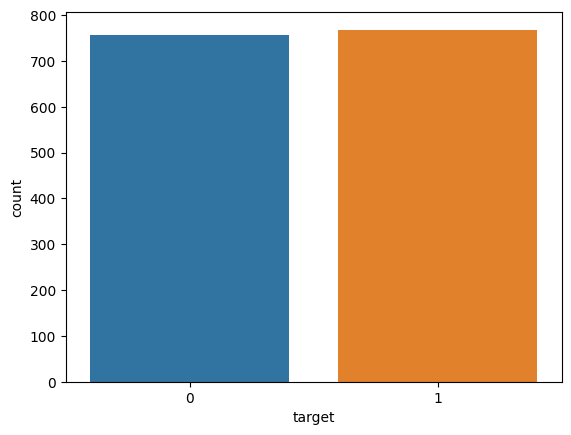

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='target', data=df)

### Processing

In [ ]:
df["texts"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'Cool place, comfortable, clean, unlike other squares, this place has a unique architecture and layout'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(df['texts'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up movie review 

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'cool place comfortable clean unlike squares place unique architecture layout'

In [ ]:
# Converting sentiment labels to 0 & 1

y = df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

In [ ]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

2306

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Classroom/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(2306, 100)

## Recurrent Neural Network (LSTM)

In [ ]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 100)          230600    
                                                                 
 conv1d_12 (Conv1D)          (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 294,857
Trainable params: 64,257
Non-trainable params: 230,600
_________________________________________________________________
None


In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
8/8 [==============================] - 1s 105ms/step - loss: 0.2593 - acc: 0.9374 - val_loss: 0.5100 - val_acc: 0.7500
Epoch 2/50
8/8 [==============================] - 1s 96ms/step - loss: 0.2318 - acc: 0.9487 - val_loss: 0.5015 - val_acc: 0.7541
Epoch 3/50
8/8 [==============================] - 1s 100ms/step - loss: 0.2092 - acc: 0.9590 - val_loss: 0.5061 - val_acc: 0.7541
Epoch 4/50
8/8 [==============================] - 1s 95ms/step - loss: 0.1895 - acc: 0.9621 - val_loss: 0.5076 - val_acc: 0.7664
Epoch 5/50
8/8 [==============================] - 1s 110ms/step - loss: 0.1711 - acc: 0.9672 - val_loss: 0.4947 - val_acc: 0.7869
Epoch 6/50
8/8 [==============================] - 1s 98ms/step - loss: 0.1539 - acc: 0.9692 - val_loss: 0.5188 - val_acc: 0.7582
Epoch 7/50
8/8 [==============================] - 1s 98ms/step - loss: 0.1422 - acc: 0.9785 - val_loss: 0.4992 - val_acc: 0.7869
Epoch 8/50
8/8 [==============================] - 1s 171ms/step - loss: 0.1319 - acc: 0.9754 -

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

10/10 [==============================] - 0s 10ms/step - loss: 0.6393 - acc: 0.7770


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6393224596977234
Test Accuracy: 0.77704918384552


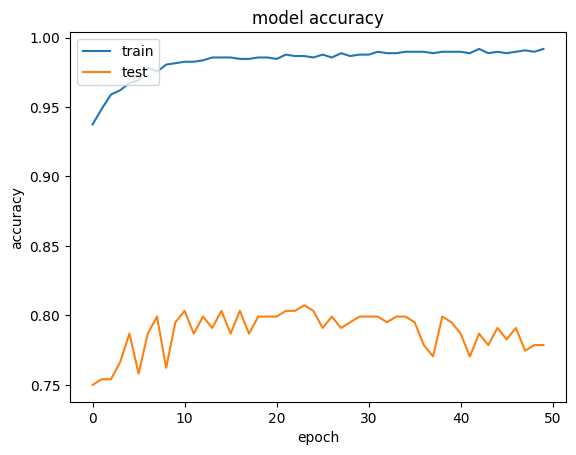

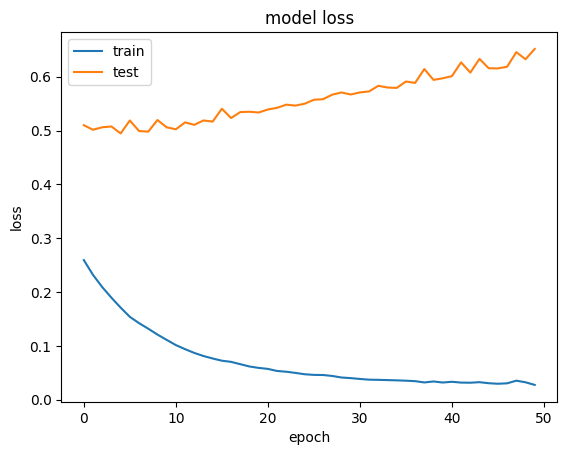

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

## Making Prediction From the Data

In [ ]:
# Load sample data

df.head(6)

,target,texts
0,0,"Monday, Many tours in Surabaya are closed."
1,1,Great Place for sightseeing and spending time ...
2,1,"Cool place, comfortable, clean, unlike other s..."
3,1,Place of education for the citizens of Surabay...
4,1,Really good
5,1,Lots of good smooth


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

reviews =df['texts']

processed = []
for review in reviews:
  review = preprocess_text(review)
  processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
tokenized2 = word_tokenizer.texts_to_sequences(processed)

# Pooling instance to have maxlength of 100 tokens
padded2 = pad_sequences(tokenized2, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
sentiments = cnn_model.predict(padded2)

sentiments

48/48 [==============================] - 2s 27ms/step


array([[0.0063168 ],
       [0.9923373 ],
       [0.9999873 ],
       ...,
       [0.9859587 ],
       [0.9997031 ],
       [0.99937385]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

df['Predicted Sentiments'] = np.round(sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(df['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_target                = pd.DataFrame(df['target'], columns = ['target'])
df_texts                 = pd.DataFrame(df['texts'], columns = ['texts'])


dfx=pd.concat([df_target, df_texts, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,target,texts,Predicted Sentiments
0,0,"Monday, Many tours in Surabaya are closed.",0.1
1,1,Great Place for sightseeing and spending time ...,9.9
2,1,"Cool place, comfortable, clean, unlike other s...",10.0
3,1,Place of education for the citizens of Surabay...,10.0
4,1,Really good,9.8
5,1,Lots of good smooth,10.0
